## Import library

In [ ]:
# -------IMPORT------- #
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
import random
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
import seaborn as sns

In [ ]:
sns.set_theme()

In [ ]:
!pip install tensorflow==2.12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Processing step

In [ ]:
def data_processing():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()

  X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255.0
  X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 1) / 255.0

  y_train_one_hot = to_categorical(y_train, num_classes=10)
  y_test_one_hot = to_categorical(y_test, num_classes=10)

  input_shape = X_train_reshaped[0].shape

  return X_train_reshaped, y_train_one_hot, X_test_reshaped, y_test_one_hot, input_shape

In [ ]:
X_train, y_train, X_test, y_test, input_shape = data_processing()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

## Decide how many pair of Convolution-Subsampling pair is well suited.


In [ ]:
netNum = 3
model = [0] * netNum
for i in range(netNum):
  model[i] = Sequential()
  model[i].add(Conv2D(filters=32, kernel_size=(5, 5), activation= 'relu', padding = 'same', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  if i > 0:
    model[i].add(Conv2D(filters=48, kernel_size=(5, 5), activation= 'relu', padding = 'same'))
    model[i].add(MaxPooling2D())
  if i > 1:
    model[i].add(Conv2D(filters=64, kernel_size=(5, 5), activation= 'relu', padding = 'same'))
    model[i].add(MaxPooling2D())

  model[i].add(Flatten())
  model[i].add(Dense(256, activation = 'relu'))
  model[i].add(Dense(10, activation = 'softmax'))
  model[i].compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [ ]:
history = [0] * netNum
name = ["1-pair", "2-pair", "3-pair"]
EPOCHS = 32
BATCH_SIZE = 32
for i in range(netNum):
  history[i] = model[i].fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, y_val), verbose = 0)
  print(f"{name[i]}: Epoch = {EPOCHS}, Train acc: {max(history[i].history['accuracy']):.4f}, Val acc: {max(history[i].history['val_accuracy']):.4f}")


1-pair: Epoch = 32, Train acc: 0.9999, Val acc: 0.9892
2-pair: Epoch = 32, Train acc: 0.9996, Val acc: 0.9909
3-pair: Epoch = 32, Train acc: 0.9991, Val acc: 0.9918


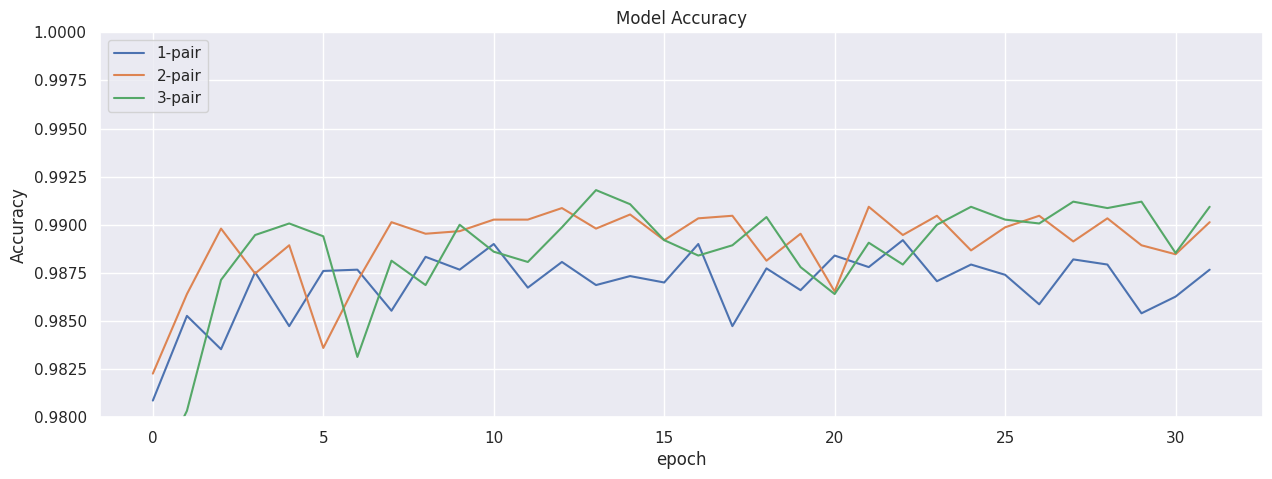

In [ ]:
plt.figure(figsize = (15,5))

for i in range(netNum):
  plt.plot(history[i].history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(name, loc = 'upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()


**Conclusion:** 2 pairs of Convolution-Subsampling is slightly better than 1 and 3 pairs in terms of accuracy and computational cost.


## Decide number of filters needed

In [ ]:
'''
8 16 / 16 32 / 24 48 / 32 64 / 48 96 / 64 128
'''
testNum = 6
model = [0] * testNum
for i in range(6):
    model[i] = Sequential()
    model[i].add(Conv2D(filters=i*8+8,kernel_size=(5, 5), activation='relu',input_shape=(28,28,1)))
    model[i].add(MaxPooling2D())

    model[i].add(Conv2D(filters=i*16+16,kernel_size=(5, 5),activation='relu'))
    model[i].add(MaxPooling2D())

    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = [0] * testNum
name = ["8_16", "16_32", "24_48", "32_64", "48_96", "64_128"]

EPOCHS = 32
BATCH_SIZE = 32

for i in range(testNum):
  history[i] = model[i].fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, y_val), verbose = 0)
  print(f"{name[i]}: Epoch {EPOCHS}, Train acc: {max(history[i].history['accuracy']):.4f}, Val acc: {max(history[i].history['val_accuracy']):.4f}")

8_16: Epoch 32, Train acc: 0.9993, Val acc: 0.9901
16_32: Epoch 32, Train acc: 0.9998, Val acc: 0.9907
24_48: Epoch 32, Train acc: 0.9995, Val acc: 0.9912
32_64: Epoch 32, Train acc: 0.9993, Val acc: 0.9915
48_96: Epoch 32, Train acc: 0.9996, Val acc: 0.9922
64_128: Epoch 32, Train acc: 1.0000, Val acc: 0.9922


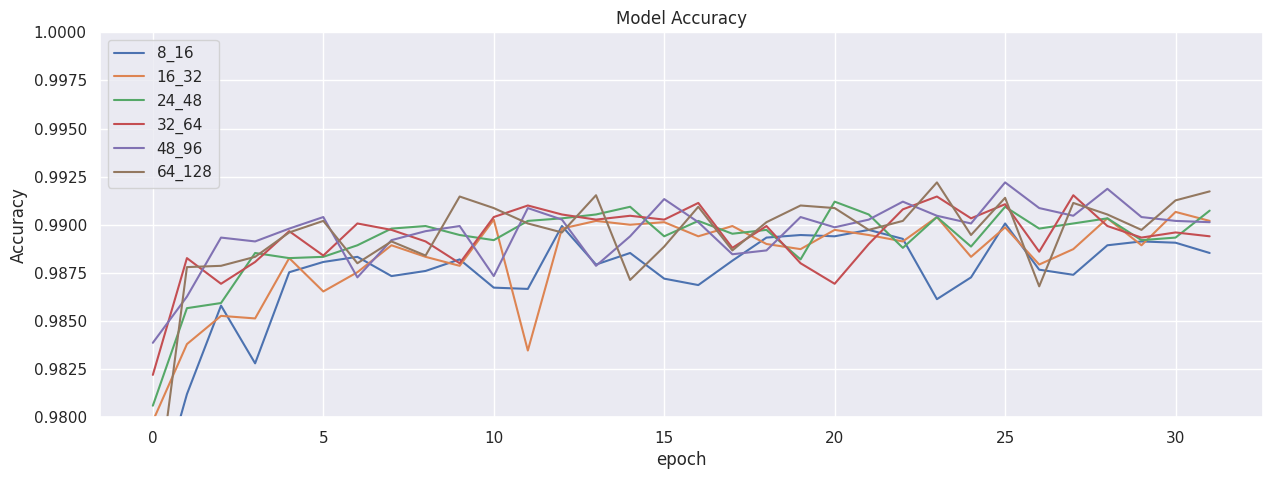

In [ ]:
plt.figure(figsize = (15,5))

for i in range(testNum):
  plt.plot(history[i].history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(name, loc = 'upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

**Conclusion:** 24 filters in first block and 48 filters in second block looks the most stable with acceptable accuracy


## Decide how large Dense layer is

In [ ]:
testNum2 = 8
model = [0] * testNum2

for i in range(testNum2):
    model[i] = Sequential()
    model[i].add(Conv2D(filters=24, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
    model[i].add(MaxPooling2D())
    model[i].add(Conv2D(filters=48, kernel_size=(5, 5),activation='relu'))
    model[i].add(MaxPooling2D())
    model[i].add(Flatten())
    if i>0:
        model[i].add(Dense(2**(i+4), activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = [0] * testNum2
name = ["0", "32", "64", "128", "256", "512", "1024", "2048"]

EPOCHS = 32
BATCH_SIZE = 32

for i in range(testNum2):
  history[i] = model[i].fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, y_val), verbose = 0)
  print(f"{name[i]}: Epoch {EPOCHS}, Train acc: {max(history[i].history['accuracy']):.4f}, Val acc: {max(history[i].history['val_accuracy']):.4f}")

0: Epoch 32, Train acc: 0.9994, Val acc: 0.9904
32: Epoch 32, Train acc: 0.9996, Val acc: 0.9906
64: Epoch 32, Train acc: 0.9997, Val acc: 0.9909
128: Epoch 32, Train acc: 0.9994, Val acc: 0.9912
256: Epoch 32, Train acc: 0.9995, Val acc: 0.9909
512: Epoch 32, Train acc: 0.9994, Val acc: 0.9917
1024: Epoch 32, Train acc: 0.9994, Val acc: 0.9913
2048: Epoch 32, Train acc: 0.9995, Val acc: 0.9909


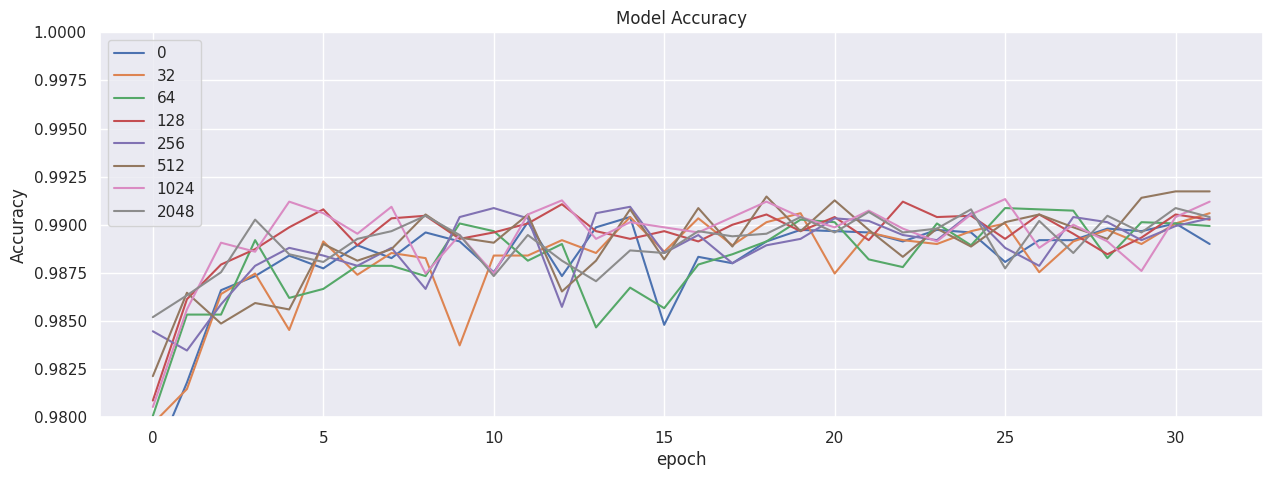

In [ ]:
plt.figure(figsize = (15,5))

for i in range(testNum2):
  plt.plot(history[i].history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(name, loc = 'upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

**Conclusion:** 256 nodes for a Dense layer

## Decide Dropout rate

In [ ]:
testNum3 = 8
model = [0] * testNum3

for i in range(8):
    model[i] = Sequential()
    model[i].add(Conv2D(filters=24, kernel_size=(5, 5), activation='relu',input_shape=(28,28,1)))
    model[i].add(MaxPooling2D())
    model[i].add(Dropout((i*0.1)))

    model[i].add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu'))
    model[i].add(MaxPooling2D())
    model[i].add(Dropout(i*0.1))

    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dropout(i*0.1))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = [0] * testNum3
name = ["0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7"]

EPOCHS = 32
BATCH_SIZE = 32

for i in range(testNum3):
  history[i] = model[i].fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, y_val), verbose = 0)
  print(f"{name[i]}: Epoch {EPOCHS}, Train acc: {max(history[i].history['accuracy']):.4f}, Val acc: {max(history[i].history['val_accuracy']):.4f}")

0: Epoch 32, Train acc: 0.9994, Val acc: 0.9917
0.1: Epoch 32, Train acc: 0.9989, Val acc: 0.9923
0.2: Epoch 32, Train acc: 0.9970, Val acc: 0.9927
0.3: Epoch 32, Train acc: 0.9949, Val acc: 0.9929
0.4: Epoch 32, Train acc: 0.9908, Val acc: 0.9929
0.5: Epoch 32, Train acc: 0.9845, Val acc: 0.9928
0.6: Epoch 32, Train acc: 0.9751, Val acc: 0.9917
0.7: Epoch 32, Train acc: 0.9553, Val acc: 0.9883


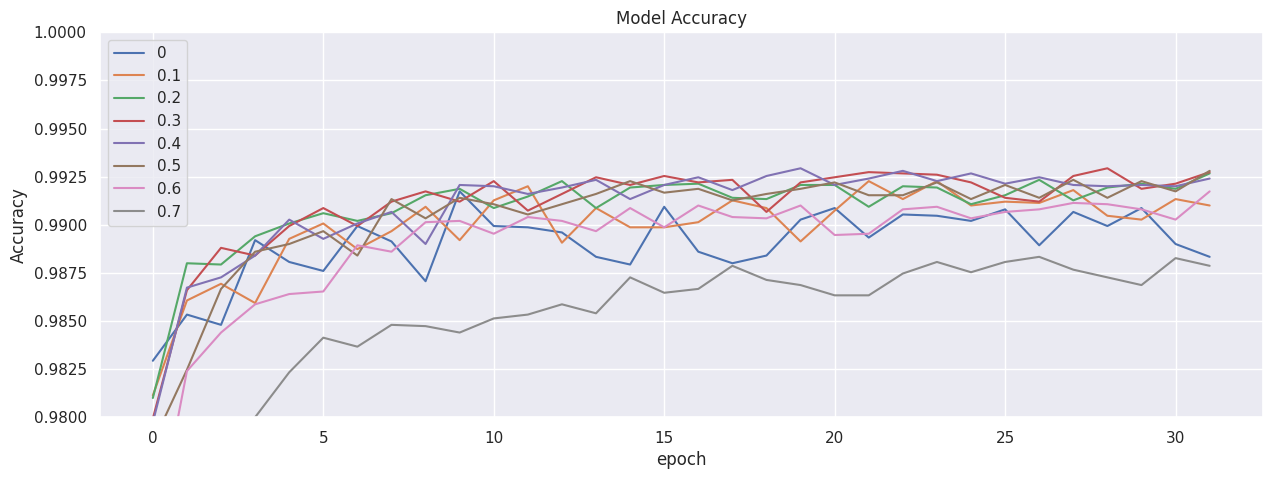

In [ ]:
plt.figure(figsize = (15,5))

for i in range(testNum3):
  plt.plot(history[i].history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(name, loc = 'upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

**Conclusion:** 0.2 dropout rate

## Final Architecture: 784 - 24C5 - 48C5 - 256 - 10 (dropout=0.2)

In [ ]:
final_model = Sequential()
final_model.add(Conv2D(filters=24, kernel_size=(5, 5), activation='relu',input_shape=(28,28,1)))
final_model.add(MaxPooling2D())
final_model.add(Dropout((0.2)))

final_model.add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Dropout(0.2))

final_model.add(Flatten())
final_model.add(Dense(256, activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(10, activation='softmax'))
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
EPOCHS = 32
BATCH_SIZE = 32

history = final_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=1)

for epoch in range(EPOCHS):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]


Epoch 1/32
1407/1407 [==============================] - 7s 4ms/step - loss: 0.1823 - accuracy: 0.9424 - val_loss: 0.0607 - val_accuracy: 0.9822
Epoch 2/32
1407/1407 [==============================] - 8s 5ms/step - loss: 0.0619 - accuracy: 0.9806 - val_loss: 0.0491 - val_accuracy: 0.9853
Epoch 3/32
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.0404 - val_accuracy: 0.9882
Epoch 4/32
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0393 - accuracy: 0.9874 - val_loss: 0.0344 - val_accuracy: 0.9905
Epoch 5/32
1407/1407 [==============================] - 6s 5ms/step - loss: 0.0327 - accuracy: 0.9892 - val_loss: 0.0399 - val_accuracy: 0.9888
Epoch 6/32
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.0431 - val_accuracy: 0.9875
Epoch 7/32
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0356 - val_accuracy:

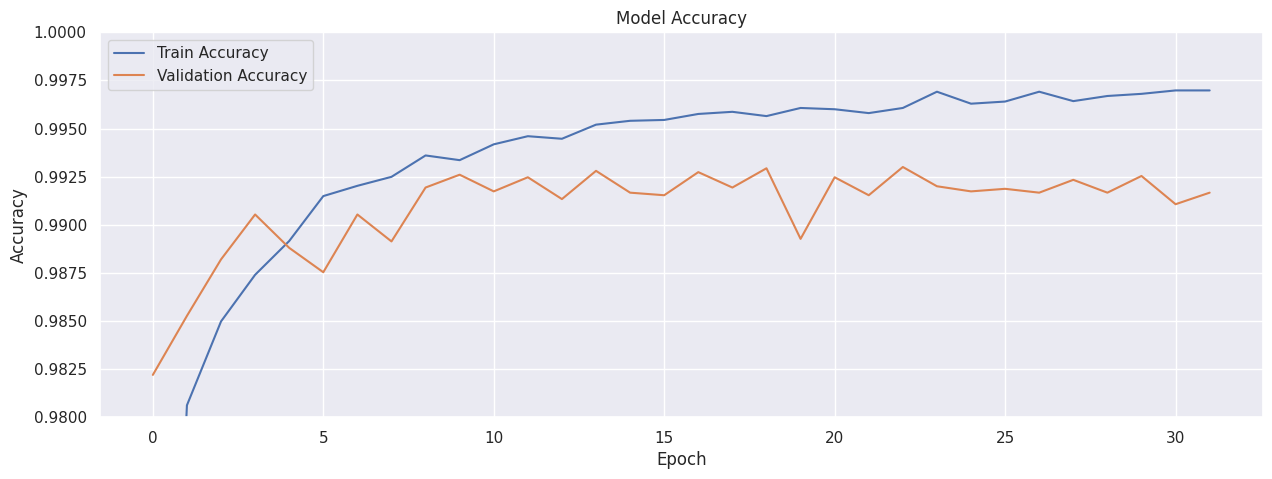

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['accuracy'], label= 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98, 1])
plt.show()


In [ ]:
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(test_acc)

0.9930999875068665


In [ ]:
final_model.save('/content/drive/MyDrive/Study and things/HUST/BKAI/MNIST testing/model.h5')